In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt

In [2]:
df = pd.read_csv("D:/TEL U/S2 TELU/SEM 2 TELU/MATLANJUT/CODE1/td.csv")

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

X = df.drop('Survived', axis=1)
y = df['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20000\174186719.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20000\174186719.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [3]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Choice('units_input', [32, 64, 128]),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    if hp.Boolean('use_hidden_layer'):
        model.add(Dense(
            units=hp.Choice('units_hidden', [32, 64, 128]),
            activation='relu'
        ))
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    rho = hp.Choice('rho', [0.8, 0.9, 0.95])
    momentum = hp.Choice('momentum', [0.0, 0.8, 0.9])
    epsilon = 1e-7

    model.compile(
        optimizer=RMSprop(learning_rate=lr, rho=rho, momentum=momentum, epsilon=epsilon),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [6]:
tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='grid_search_rmsprop',
    project_name='titanic_rmsprop'
)

In [7]:
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Trial 20 Complete [00h 00m 05s]
val_accuracy: 0.8391608595848083

Best val_accuracy So Far: 0.867132842540741
Total elapsed time: 00h 01m 29s


In [8]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6277 - loss: 0.6134 - val_accuracy: 0.8322 - val_loss: 0.4281
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7834 - loss: 0.4933 - val_accuracy: 0.8322 - val_loss: 0.4104
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7910 - loss: 0.4696 - val_accuracy: 0.8322 - val_loss: 0.3878
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8204 - loss: 0.4211 - val_accuracy: 0.8322 - val_loss: 0.3918
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8315 - loss: 0.4059 - val_accuracy: 0.8252 - val_loss: 0.3890
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8553 - loss: 0.3993 - val_accuracy: 0.8392 - val_loss: 0.3873
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8344 - loss: 0.3941 - val_accuracy: 0.8322 - val_loss: 0.3913
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8439 - loss: 0.4029 - val_accuracy: 0.8462 - val_loss

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"✅ Grid Search - Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8260 - loss: 0.4267 
✅ Grid Search - Test Accuracy: 0.8268
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179

Confusion Matrix:
 [[95 10]
 [21 53]]


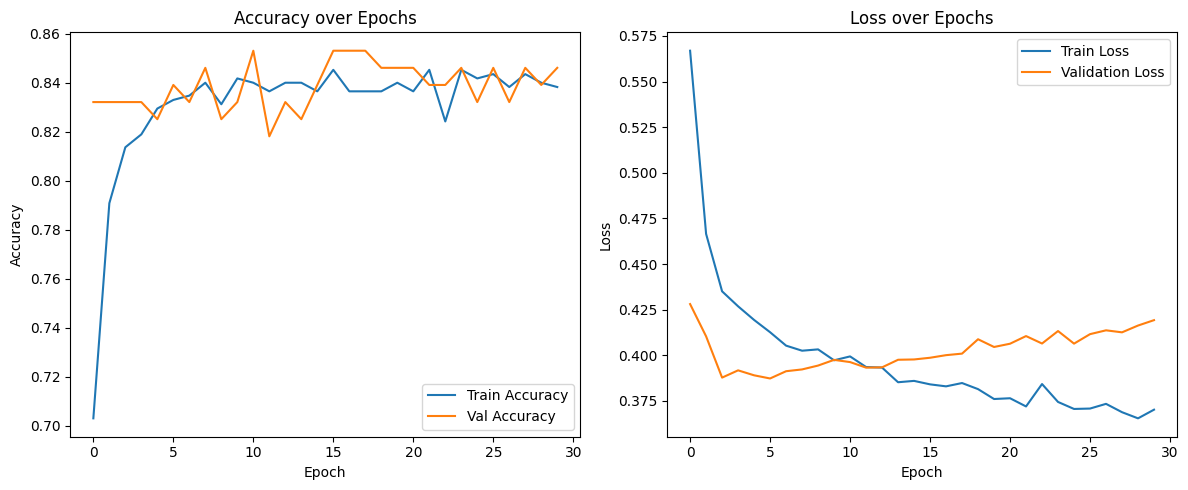

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


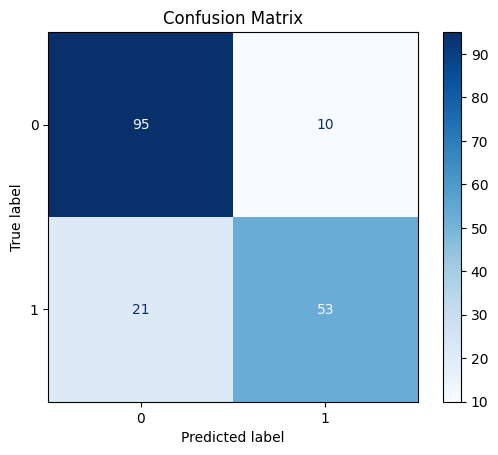

In [11]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()